We will be building on top of [this notebook](https://github.com/dipanjanS/adversarial-learning-robustness/blob/main/tutorials/attacks/02_1_targeted_pgd.ipynb). We will learn how to launch a targeted PGD-based attack on [EfficientNet](https://arxiv.org/pdf/1905.11946) and its [Noisy Student (NST)](https://arxiv.org/abs/1911.04252) variant. It will be clear that under the same hyperparameter configurations, they perform better than other networks like ResNet50. 

**Note**: EfficientNet models in `tf.keras.applications` take care of normalization as a part of in-model preprocessing. So, we don't need to apply any pixel scaling beforehand. 

## Initial setup and imports

In [10]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2

print("TensorFlow version: ",tf.__version__)

TensorFlow version:  2.12.0


We first download a sample image which we will perturb in order to fool our pre-trained image classifier. We also download a dictionary that contains the mapping between the Imagenet dataset class labels and their ids.

In [11]:
!wget -q https://adversarial-ml-tutorial.org/introduction/pig.jpg
!wget -q https://raw.githubusercontent.com/USCDataScience/dl4j-kerasimport-examples/master/dl4j-import-example/data/imagenet_class_index.json

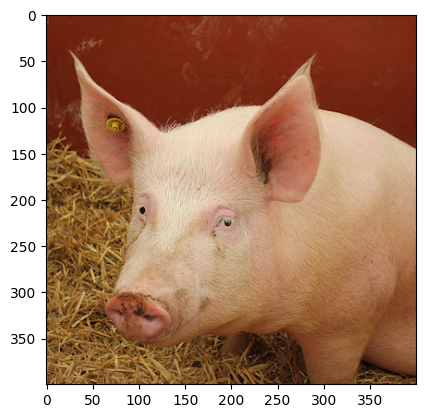

In [12]:
#show the image downloaded

im1 = plt.imread("pig.jpg")
plt.imshow(im1)
plt.show()


## A few early constants

In [13]:
EPS = 2./255
IMAGENET_LABELS = "imagenet_class_index.json"
#print(IMAGENET_LABELS)

with open(IMAGENET_LABELS) as f:
    IMAGENET_CLASSES = {int(i):x[1] for i,x in json.load(f).items()}

print(IMAGENET_CLASSES)
print(len(IMAGENET_CLASSES))

{0: 'tench', 1: 'goldfish', 2: 'great_white_shark', 3: 'tiger_shark', 4: 'hammerhead', 5: 'electric_ray', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich', 10: 'brambling', 11: 'goldfinch', 12: 'house_finch', 13: 'junco', 14: 'indigo_bunting', 15: 'robin', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water_ouzel', 21: 'kite', 22: 'bald_eagle', 23: 'vulture', 24: 'great_grey_owl', 25: 'European_fire_salamander', 26: 'common_newt', 27: 'eft', 28: 'spotted_salamander', 29: 'axolotl', 30: 'bullfrog', 31: 'tree_frog', 32: 'tailed_frog', 33: 'loggerhead', 34: 'leatherback_turtle', 35: 'mud_turtle', 36: 'terrapin', 37: 'box_turtle', 38: 'banded_gecko', 39: 'common_iguana', 40: 'American_chameleon', 41: 'whiptail', 42: 'agama', 43: 'frilled_lizard', 44: 'alligator_lizard', 45: 'Gila_monster', 46: 'green_lizard', 47: 'African_chameleon', 48: 'Komodo_dragon', 49: 'African_crocodile', 50: 'American_alligator', 51: 'triceratops', 52: 'thunder_snake', 53: 'ringneck_snake', 54: 'hogn

## Utility functions

Next we define a couple of utility functions that we will be using throughout the course of this notebook.

In [14]:
# Function to load up an image from a local filepath and
# display it
def show_image(image_path):
    image_pixels = plt.imread(image_path)
    plt.imshow(image_pixels)
    plt.show()
    return image_pixels

# Function to preprocess an image for performing inference
def preprocess_image(image_pixels):
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, axis=0)
    return image_pixels

# Clipping utility to project delta back to our favorable pixel
# range ([0 ,1])
def clip_eps(delta_tensor):
    return tf.clip_by_value(delta_tensor, 
                            clip_value_min=-EPS, 
                            clip_value_max=EPS)

# Parse the label
def get_label(preds):
    print(IMAGENET_CLASSES[preds.argmax()])

## Downloading the noisy student training weights and preparing them

In [15]:
!wget -q https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b0.tar.gz
!tar -xf noisy_student_efficientnet-b0.tar.gz

!wget -q https://raw.githubusercontent.com/yixingfu/tensorflow/updateweights/tensorflow/python/keras/applications/efficientnet_weight_update_util.py
!python efficientnet_weight_update_util.py --model b0 --ckpt \
       noisy_student_efficientnet-b0/model.ckpt --o efficientnetb0.h5

2023-04-14 11:58:57.737791: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-14 11:59:00.176859: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
check variables match in each block
blocks_0 and block1a match.
blocks_1 and block2a match.
blocks_2 and block2b match.
blocks_3 and block3a match.
blocks_4 and block3b match.
blocks_5 and block4a match.
blocks_6 and block4b match.
blocks_7 and block4c match.
blocks_8 and block5a match.
blocks_9 and block5b match.
blocks_10 and block5c match.
blocks_11 and block6a match.
blocks_12 and block6b match.
blocks_13 and block6c match.
blocks_14 and block6d match.
blocks_15 and block7a match.
skipping variable normalization/mean:0: normalization is a layerin keras implementation, but preprocessing in TF implementation.
skipping variable normalization/variance:

## Loading our first image and pre-trained models

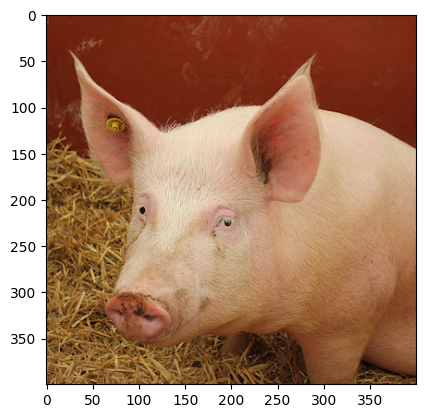

In [16]:
sample_image = show_image("pig.jpg")
preprocessed_image = preprocess_image(sample_image)
enb0 = tf.keras.applications.EfficientNetB0(weights="imagenet")
enb0_nst = tf.keras.applications.EfficientNetB0(weights="efficientnetb0.h5")

## Running inference with the pre-trained models

In [17]:
# Run inference EfficientNetB0 (ImageNet)
preds = enb0.predict(preprocessed_image)
print("Predicted:", decode_predictions(preds, top=3)[0])
print("Class idx:", preds.argmax())

1/1 [==============================] - 2s 2s/step
Predicted: [('n02395406', 'hog', 0.9617194), ('n02396427', 'wild_boar', 0.0067761717), ('n03935335', 'piggy_bank', 0.0008338953)]
Class idx: 341


In [18]:
# Run inference EfficientNetB0 (NST)
preds = enb0_nst.predict(preprocessed_image)
print("Predicted:", decode_predictions(preds, top=3)[0])
print("Class idx:", preds.argmax())

1/1 [==============================] - 1s 1s/step
Predicted: [('n02395406', 'hog', 0.95926934), ('n02396427', 'wild_boar', 0.011101305), ('n03935335', 'piggy_bank', 0.00037483755)]
Class idx: 341


## Utility functions for adversarial attacks

In [25]:
def generate_adversaries_targeted(image_tensor, delta, model,
    true_index, target_index):
    # Loss and optimizer
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)

    for t in range(500):
        plt.show()
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = image_tensor + delta
            predictions = model(inp, training=False)
            loss = (- scc_loss(tf.convert_to_tensor([true_index]), predictions) + 
	                    scc_loss(tf.convert_to_tensor([target_index]), predictions))
            if t % 20 == 0:
                print(t, loss.numpy())
            
        # Get the gradients
        gradients = tape.gradient(loss, delta)
        
        # Update the weights
        optimizer.apply_gradients([(gradients, delta)])

        # Project the delta back (l-infinite norm)
        delta.assign_add(clip_eps(delta))

    return delta

def perturb_image(image_path, true, target, model):
    # Load and preprocess image but a but without any `preprocess_input`
    sample_image = show_image(image_path)
    preprocessed_image = preprocess_image(sample_image)

    # Generate predictions before any adversaries
    unsafe_preds = model.predict(preprocessed_image)
    print("Prediction before adv.:", decode_predictions(unsafe_preds, top=3)[0])

    # Initialize the perturbation quantity
    image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    # Get the learned delta and display it
    delta_tensor = generate_adversaries_targeted(image_tensor, delta, model, true, target)
    plt.imshow(50*delta_tensor.numpy().squeeze()+0.5)
    plt.show()

    # See if the image changes
    plt.imshow((image_tensor + delta_tensor).numpy().squeeze()/255)
    plt.show()

    # Generate prediction
    perturbed_image = image_tensor + delta_tensor
    preds = model.predict(perturbed_image)
    print("Prediction after adv.:", decode_predictions(preds, top=3)[0])

Note that the hyperparameters like learning rate, number of epochs were determined after empirical experiments and also by referring to [this tremendous tutorial](https://adversarial-ml-tutorial.org/introduction/).

## Launching a targeted attack!

Let's try to make our model believe that the hog is actually a `Lakeland_terrier`. Recall that the class index of hog in the ImageNet dataset is 341 and for Lakeland_terrier it's 189.

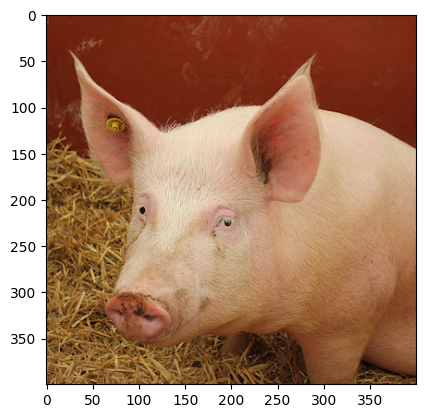

1/1 [==============================] - 0s 25ms/step
Prediction before adv.: [('n02395406', 'hog', 0.9617194), ('n02396427', 'wild_boar', 0.0067761717), ('n03935335', 'piggy_bank', 0.0008338953)]
0 10.811858
20 9.073357
40 7.6089087
60 6.424839
80 5.47793
100 4.701957
120 4.0426254
140 3.46727
160 2.9546869
180 2.49004
200 2.0629926
220 1.6661687
240 1.2932844
260 0.93743896
280 0.59068775
300 0.24497414
320 -0.11060524
340 -0.4908862
360 -0.9150181
380 -1.4159155
400 -2.0637572
420 -2.9973905
440 -4.3802195
460 -6.631428
480 -9.565583


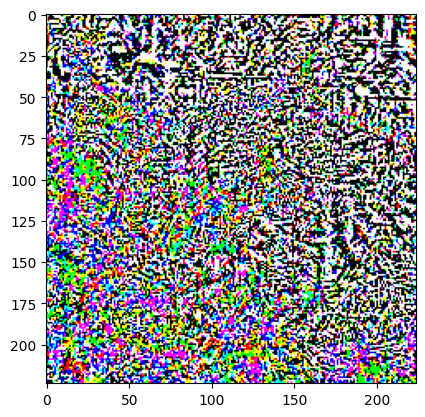

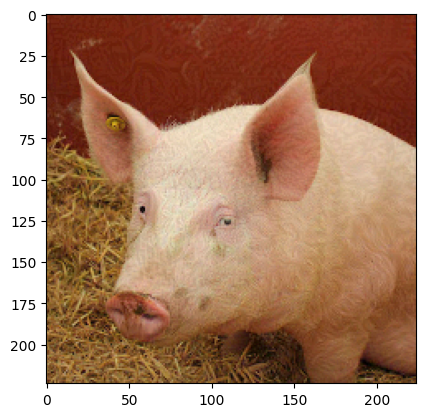

1/1 [==============================] - 0s 42ms/step
Prediction after adv.: [('n02095570', 'Lakeland_terrier', 0.85785884), ('n04399382', 'teddy', 0.028381871), ('n02095314', 'wire-haired_fox_terrier', 0.021652734)]


In [26]:
# With Efficient + ImageNet pre-trained weights
perturb_image("pig.jpg", 341, 189, enb0)

In [27]:
print(IMAGENET_CLASSES[189])

Lakeland_terrier


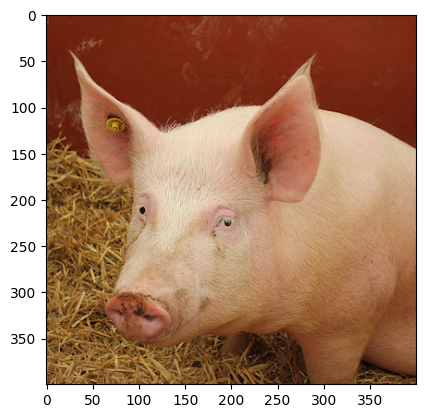

1/1 [==============================] - 0s 37ms/step
Prediction before adv.: [('n02395406', 'hog', 0.95926934), ('n02396427', 'wild_boar', 0.011101305), ('n03935335', 'piggy_bank', 0.00037483755)]
0 10.30875
20 8.912902
40 7.818789
60 6.932447
80 6.217144
100 5.6579533
120 5.2059355
140 4.8157015
160 4.461153
180 4.1322927
200 3.828825
220 3.5451293
240 3.278594
260 3.0266917
280 2.7860131
300 2.5544264
320 2.3312926
340 2.1180458
360 1.9154298
380 1.7222819
400 1.536336
420 1.35462
440 1.1738367
460 0.99139214
480 0.80641556


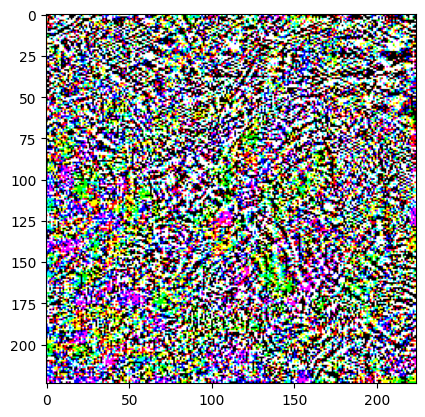

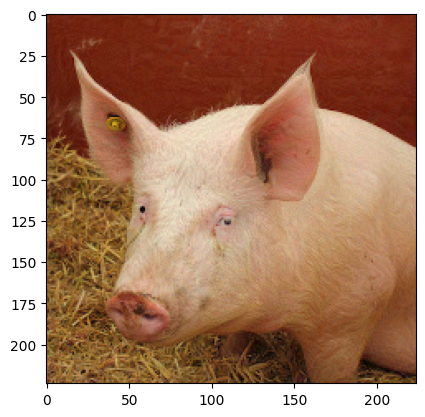

1/1 [==============================] - 1s 1s/step
Prediction after adv.: [('n02395406', 'hog', 0.008042984), ('n02397096', 'warthog', 0.004400834), ('n02095570', 'Lakeland_terrier', 0.0043387804)]


In [28]:
# With Efficient + Noisy Student Training weights
perturb_image("pig.jpg", 341, 189, enb0_nst)

We can see that under similar hyperparameter configurations we weren't able to target EfficientNet variants with adversarial perturbations.